#### RL Course by David Silver

## Reinforcement Learning Assignment: Easy21

The goal of this assignment is to apply reinforcement learning methods to a simple card game that we call *Easy21*. This exercise is similar to the Blackjack example in Sutton and Barto 5.3 – please note, however, that the rules of the card game are different and non-standard.

 - The game is played with an infinite deck of cards (i.e. cards are sample with replacement)
 - Each draw from the deck results in a value between 1 and 10 (uniforml distributed) with a colour of red (probability 1/3) or black (probability 2/3).
 - There are no aces or picture (face) cards in this game
 - At the start of the game both the player and the dealer draw one *black* card (fully observed)
 - Each turn the player may either *stick* or *hit*
 - If the player *hits* then she draws another card from the deck
 - If the player *sticks* she receives no further cards
 - The values of the player’s cards are added (black cards) or subtracted (red cards)
 - If the player’s sum exceeds 21, or becomes less than 1, then she “goes bust” and loses the game (reward -1)
 - If the player sticks then the dealer starts taking turns. The dealer always sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome – win (reward +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1 Implementation of Easy21

In [3]:
class Player:
    '''Player of Easy21 game.
    
    Attributes:
        current_points: A integer of player's maximum current points
    '''
    def __init__(self):
        self.current_points = 0
        
    def get_card(self, card):
        '''Get a card from the card deck.'''
        self.current_points += card

class Dealer(Player):
    '''Dealer of Easy21 game, another kind of player.
    
    Attributes:
        first_card: A integer, the number of dealer's first card, 'black' is guaranteed.
    '''
    def __init__(self):
        Player.__init__(self)
        self._first_step = True
        self.first_card = 0
    
    def get_card(self, card):
        '''Get a card, and mark the first card as first_card.'''
        if self._first_step:
            self._first_step = False
            self.first_card = card
        Player.get_card(self, card)


class Easy21:
    '''Easy21 game.
    
    Attributes:
        
    
    Methods:
        step
        reset
        
    '''
    action_space = [0, 1] # 1: hit, 0: stick
    
    winner_to_reward = {
        'player' :  1,
        'dealer' : -1,
        'none'   :  0,
        ''       :  0
    }
    
    def __init__(self):
        self._player = Player()
        self._dealer = Dealer()
        self.reset()
    
    def reset(self):
        self._player.current_points = 0
        self._dealer.current_points = 0
        self._dealer._first_step = True 
        self._player.get_card(np.random.randint(1, 11)) # first card, 'black' guanranteed
        self._dealer.get_card(np.random.randint(1, 11))
        self.winner = ''
        self.is_terminate = False
        return self._get_state()
    
    def step(self, action):
        '''Get one time step forward.
        
        Args:
            action
        Returns:
            next state
            reward
            is_terminate
            DEBUG_INFO
        '''
        assert action in self.action_space
        if action:
            self._hit()
            if self.winner != '':
                self.is_terminate = True
        else:
            self._stick()
            self.is_terminate = True
        return  self._get_state(), self.winner_to_reward[self.winner], self.is_terminate, {}
    
    @staticmethod
    def _generate_card():
        '''generate a card range from 1 to 10 with 2/3 probability 
                    and range from -1 to -10 with 1/3 probability  
        '''
        return np.random.randint(1, 11) * -int(((np.random.randint(0, 3) % 2) - 1 / 2) * 2)
    
    def _stick(self):
        while self._dealer.current_points < 17 and self._dealer.current_points > 0:
            self._dealer.get_card(self._generate_card())
        if self._dealer.current_points > 21 or self._dealer.current_points < 1:
            self.winner = 'player'
        elif self._dealer.current_points < self._player.current_points:
            self.winner = 'player'
        elif self._dealer.current_points == self._player.current_points:
            self.winner = 'none'
        else:
            self.winner = 'dealer'
            
    def _hit(self):
        self._player.get_card(self._generate_card())
        if self._player.current_points > 21 or self._player.current_points < 1:
            self.winner = 'dealer'
            
    def _get_state(self):
        '''
        Return current game state: 
        player's point and dealer's first card 
        '''
        return (self._player.current_points, self._dealer.first_card)
    
    

In [4]:
env = Easy21()
s = env.reset()
done = False
while not done:
    s, r, done, _ = env.step(np.random.randint(2))
    print(s, r, done)

(18, 9) 0 False
(18, 9) -1 True


In [5]:
def naive_policy(state):
    return 1 if state[0] < 20 else 0

In [6]:
from collections import defaultdict, Counter,deque
def MC_Learning(MDP, episodes, policy, gamma = 1):
    episode = 0
    V = defaultdict(float)
    N = Counter()
    while episode < episodes:
        S = deque()
        R = deque()
        G = 0
        s = MDP.reset()
        done = False
        while not done:
            S.append(s)
            a = policy(s)
            s, r, done, _ = MDP.step(a)
            R.append(r)
        while len(S) > 0:
            s = S.pop()
            r = R.pop()
            G = gamma * G + r
            N[s] += 1
            V[s] += (G - V[s])/ N[s]
        episode += 1
    return V

In [10]:
env = Easy21()
V = MC_Learning(env, 1000000, naive_policy)

In [16]:
def plot_result(V, title):
    max_x = max(x[0] for x in V)
    min_x = min(x[0] for x in V)
    max_y = max(x[1] for x in V)
    min_y = min(x[1] for x in V)
    
    x = np.arange(min_x, max_x+1)           # 生成 x 坐标，表示玩家此刻的点数
    y = np.arange(min_y, max_y+1)             # 生成 y 坐标，表示庄家的明牌
    X, Y = np.meshgrid(x, y)        # 生成 meshgrid
    # 画图
    Z = np.apply_along_axis(lambda _: V[(_[0], _[1])], 2, np.dstack([X, Y]))
    fig = plt.figure(figsize=(10, 5))
    ax = Axes3D(fig)
    ax.plot_surface(Y, X, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, vmin=-1, vmax=1)
    ax.set_xlabel("Dealer's face-up card")
    ax.set_ylabel("Player's Points")
    fig.suptitle(title)

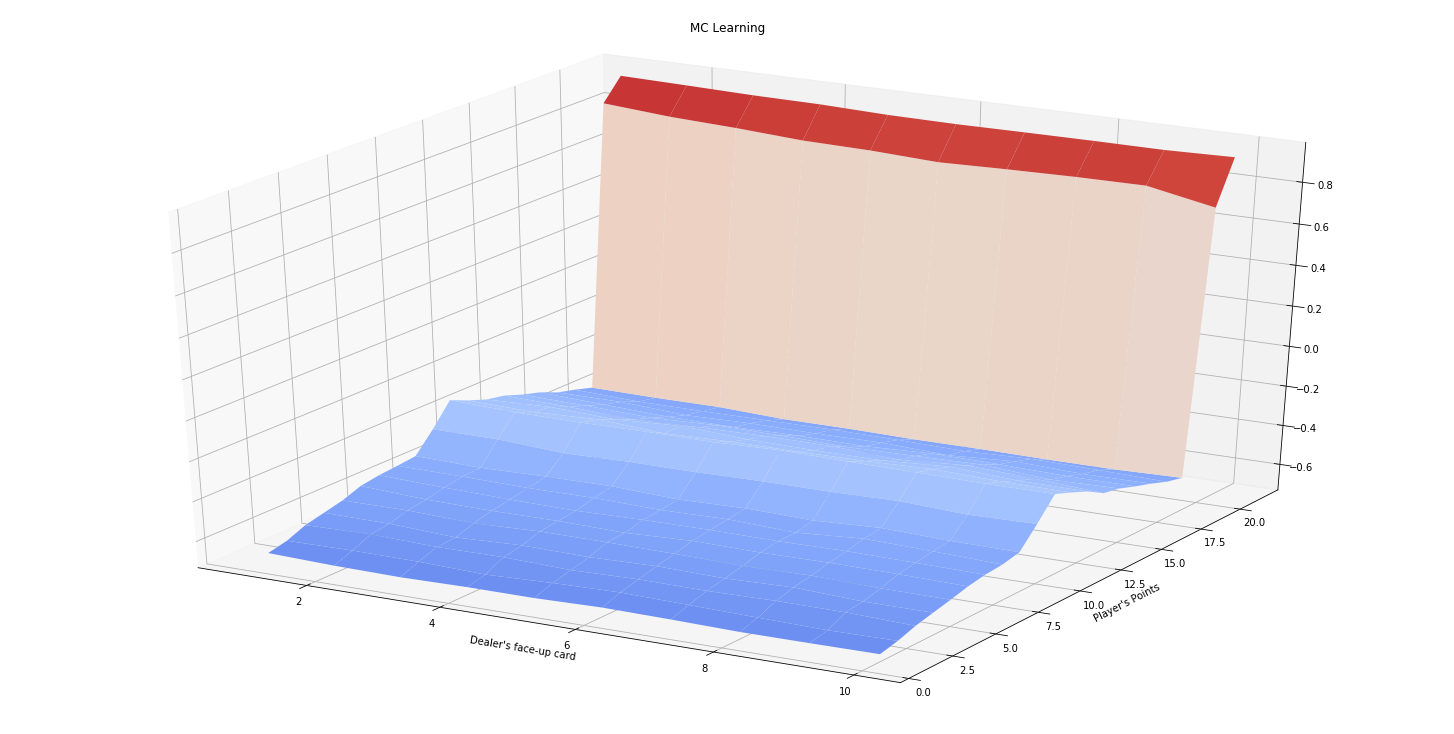

In [18]:
plot_result(V, 'MC Learning')